In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import random
import warnings
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
from sklearn.exceptions import ConvergenceWarning

try:
    from myst_nb import glue
except ImportError:
    glue = lambda *args, **kwargs: _
# 一部の警告を無視
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", FutureWarning)
os.environ["PYTHONWARNINGS"] = "ignore"

In [33]:

# Excelファイルの読み込み
train2=0
if train2:
    excel_file = pd.read_excel('../../../Downloads/train_data2.xlsx',header=None)
else:
    excel_file = pd.read_excel('../../../Downloads/train_data3.xlsx',header=None)
# excel_file = pd.read_excel('../../../Downloads/train_data3.xlsx',header=None)
excel_file.shape

(100, 100)

(3715, 3572, 3)
(6000, 6000)


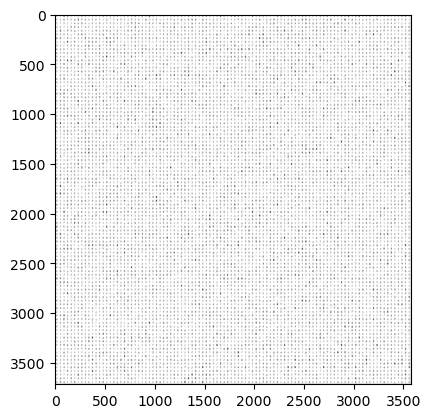

In [34]:


# 画像を読み込む
pixel=60
if train2:
    img = cv2.imread('../../../Pictures/train2.png', cv2.IMREAD_COLOR)
else:
    img = cv2.imread('../../../Pictures/train3.png', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
V,H,_=img.shape
N,M=100,100


    # 処理が完了した画像を保存するなどの操作を行うことができます
plt.imshow(img, cmap='gray')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# gray=cv2.GaussianBlur(gray, None, 3.0)
# img = cv2.dilate(gray, np.ones((1, 1), dtype="double"),iterations=1)
# img = cv2.erode(img, np.ones((1, 1), dtype="double"),iterations=1)
# img=cv2.bitwise_not(img)

# thr, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
# img_inv=cv2.bitwise_not(gray)
# img_inv=gray.copy()
# plt.imshow(img_inv, cmap='gray')
plt.imshow(img, cmap='gray')
print(img.shape)
img_rs=cv2.resize(gray,(pixel*M,pixel*N),interpolation=cv2.INTER_AREA)
img_rs=cv2.bitwise_not(img_rs)
print(img_rs.shape)


In [35]:
Xs=[]
Ys=[]
for i in range(N):
    for j in range(M):
        digit_square = img_rs[i*pixel:(i+1)*pixel, j*pixel:(j+1)*pixel]
        x_i=digit_square.reshape(1, -1)
        # print(x_i.shape,i,j)
        y=excel_file.iloc[i,j]
        Xs.append(x_i)
        Ys.append(y)
        

Xs=pd.DataFrame(np.array(Xs).reshape(N*M,-1))
Ys=pd.DataFrame(np.array(Ys).reshape(N*M,-1),columns=['label'])
print(Xs.shape,Ys.shape)
df=pd.concat([Ys,Xs],axis=1)
df=df.loc[df.iloc[:,0]!=0]
df.shape


(10000, 3600) (10000, 1)


(10000, 3601)

2

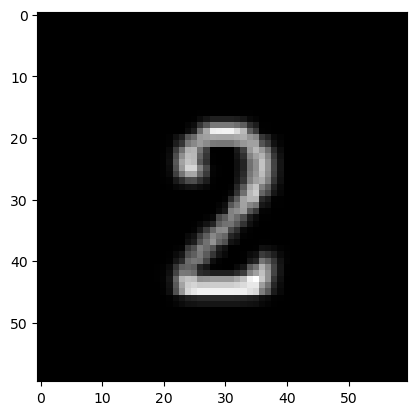

In [36]:
i,j=10,5
plt.imshow(img_rs[i*pixel:(i+1)*pixel, j*pixel:(j+1)*pixel], cmap='gray')
excel_file.iloc[i,j]

In [37]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

X_org, y_org = df.iloc[:,1:], df.iloc[:,0]
X_org = np.array(X_org / 255.0, dtype="double")
y_org = np.array(y_org, dtype="uint8")
X, X_test, y, y_test = model_selection.train_test_split(
    X_org, y_org,test_size=0.2, shuffle=True,random_state=42
)
# # use partial data 
# # n_samples = 10000  
# # X, y = X[:n_samples], y[:n_samples]
# # X_test, y_test = X_test[:n_samples], y_test[:n_samples]

# スケーリングパラメータの計算
scaler = StandardScaler()
scaler.fit(X)

# データのスケーリング
X = scaler.transform(X)
X_test = scaler.transform(X_test)

# 訓練モデルの構築
lr_params = {"tol": 1.0e-3, "max_iter": 5000, "solver": "lbfgs"}
# clf = LogisticRegression(**lr_params)
# clf = RandomForestClassifier()
# clf= KNeighborsClassifier(n_neighbors=20)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

# 訓練モデルの構築
clf = SVC(kernel="linear", C=1.0, tol=1.0e-2, max_iter=-1)
# clf = SVC(kernel="rbf", C=1.0, tol=1.0e-2, max_iter=-1)
clf.fit(X, y)

# # # # 訓練モデルの構築 (弱識別器にロジスティック回帰を使用)
# # # # weak = LogisticRegression(**lr_params)
# # # # clf = AdaBoostClassifier(estimator=weak, n_estimators=100)
# # # clf.fit(X, y)
acc_train = 100.0 * clf.score(X, y)
print("logis_acc_train", acc_train)

# テストデータに対する識別精度の計算
acc_test = 100.0 * clf.score(X_test, y_test)
print("logis_acc_test", acc_test)

logis_acc_train 100.0
logis_acc_test 99.8


In [38]:
# # データセットを3つに分割
# # 訓練: 50000, 検証: 10000, テスト: 10000
# X, X_test, y, y_test = model_selection.train_test_split(
#     X_org, y_org, test_size=0.15, shuffle=True
# )

# X, X_val, y, y_val = model_selection.train_test_split(
#     X, y, test_size=0.15, shuffle=True
# )


# # 計算量を落とすため、訓練データの数を絞る
# # X, y = X[:n_samples], y[:n_samples]
# # X_val, y_val = X_val[:n_samples], y_val[:n_samples]
# # X_test, y_test = X_test[:n_samples], y_test[:n_samples]
# from itertools import product

# # グリッドサーチによる最適パラメータを探索
# max_acc = 0.0
# best_params = None

# C_range = [0.01, 1.0, 100.0]
# gamma_range = [0.1, 1.0, 10.0]
# param_grid = {"C": C_range, "gamma": gamma_range}
# gs_df = pd.DataFrame(columns=(list(param_grid.keys()) + ["Accuracy"]))

# best_index = 0
# param_sets = list(product(*param_grid.values()))
# for i, params in enumerate(tqdm(param_sets)):
#     param_dict = {list(param_grid.keys())[i]: v for i, v in enumerate(params)}
#     clf = SVC(kernel="rbf", tol=1.0e-4, max_iter=20, **param_dict)
#     clf.fit(X, y)

#     # 精度の計算
#     y_pred = clf.predict(X_val)
#     acc_val = 100.0 * np.sum(y_pred == y_val) / len(y_val)

#     # データを追加
#     new_row = {k: v for k, v in param_dict.items()}
#     new_row["Accuracy"] = acc_val
#     gs_df.loc[len(gs_df), :] = list(new_row.values())

#     # ベスト・パラメータの更新
#     if max_acc < acc_val:
#         best_index = i
#         max_acc = acc_val
#         best_params = param_dict
# # 最適パラメータでの再学習
# clf = SVC(kernel="rbf", tol=1.0e-4, max_iter=100, **best_params)
# clf.fit(X, y)
# acc_train = 100.0 * clf.score(X, y)
# print("logis_acc_train", acc_train)

# # テストデータに対する識別精度の計算
# acc_test = 100.0 * clf.score(X_test, y_test)
# print("logis_acc_test", acc_test)

In [39]:
# from sklearn.model_selection import GridSearchCV

# # C_range = [0.01, 1.0, 100.0]
# # gamma_range = [0.1, 1.0, 10.0]
# # param_grid = {"C": C_range, "gamma": gamma_range}

# # svc = SVC(kernel="rbf", tol=1.0e-4, max_iter=30)
# # cv = GridSearchCV(svc, param_grid, cv=4, n_jobs=8, verbose=2)

# max_feature_range = ["sqrt","log2"]
# min_samples_split_range = [2, 4, 8]
# # n_estimators_range = [10, 100, 200]
# param_grid = {"min_samples_split":min_samples_split_range, "max_features": max_feature_range}
# clf=RandomForestClassifier(n_estimators=20)
# cv=GridSearchCV(clf,param_grid,cv=4,n_jobs=8,verbose=2)
# ret = cv.fit(X, y)
# clf = RandomForestClassifier(**ret.best_params_)
# clf.fit(X, y)
# acc_train = 100.0 * clf.score(X, y)
# print("logis_acc_train", acc_train)

# # テストデータに対する識別精度の計算
# acc_test = 100.0 * clf.score(X_test, y_test)
# print("logis_acc_test", acc_test)

In [40]:
clf.predict(X_test)

array([7, 3, 8, ..., 4, 2, 4], dtype=uint8)

In [41]:
df

,label,0,1,2,3,4,5,6,7,8,...,3590,3591,3592,3593,3594,3595,3596,3597,3598,3599
0,2,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,0,0,0,0,0
1,5,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,0,0,0,0,0
2,4,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,0,0,0,0,0
3,2,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,0,0,0,0,0
4,2,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4,0,0,0,0,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,255
9996,1,0,0,0,0,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,255
9997,2,0,0,0,0,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,255
9998,2,0,0,0,0,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,255


In [42]:
import pickle
# save model and scaler
# with open('./pickle/rf_clf.pickle', mode='wb') as fp:
#     pickle.dump(clf, fp)
# with open('./pickle/rf_scaler.pickle', mode='wb') as fp:
#     pickle.dump(scaler, fp)

# reload
# scaler = pd.read_pickle('./pickle/rf_scaler.pickle')
# clf=pd.read_pickle('./pickle/rf_clf.pickle')
# X_test = scaler.transform(X_test)
# acc_test = 100.0 * clf.score(X_test, y_test)
# print("rf_acc_test", acc_test)

105.0


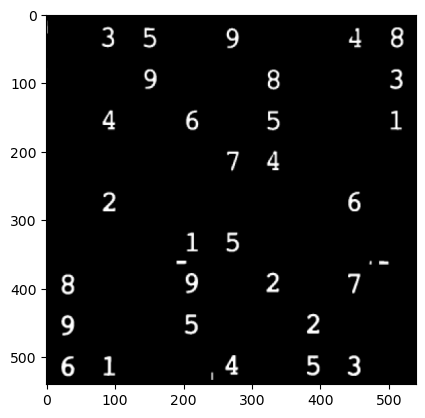

In [48]:
import recog
import recog_l2
# cropped=recog.recognize(path="./data/level_1.jpg")
# cropped=recog_l2.recognize(path="./data/level_1.jpg")
cropped=recog_l2.recognize(path="./data/level_2_2.jpg")
plt.imshow(cropped, cmap='gray')
cropped_rs = cv2.resize(cropped, (pixel*9,pixel*9),interpolation=cv2.INTER_AREA)
# cropped_rs=cv2.bitwise_not(cropped_rs)
cropped_region_=cropped_rs.copy()
plt.imshow(cropped_rs, cmap='gray')

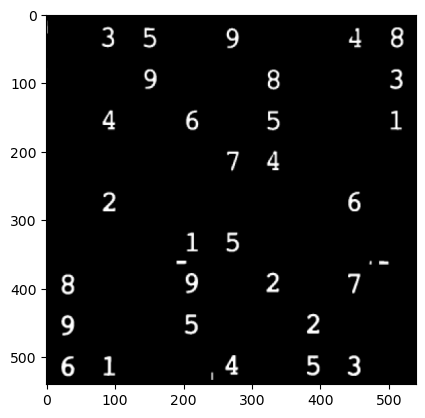

In [49]:
cropped_rs.shape
plt.imshow(cropped_rs, cmap='gray')

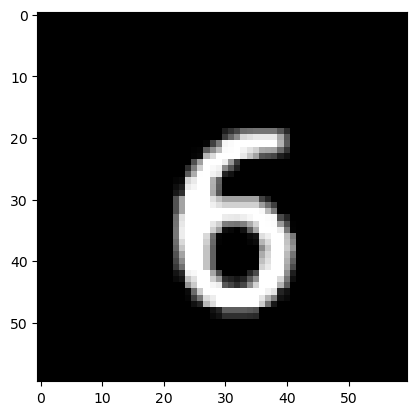

In [50]:
i,j=2,3
def plot_ij(i,j):
    plt.imshow(cropped_rs[i*pixel:(i+1)*pixel, j*pixel:(j+1)*pixel], cmap='gray')
plot_ij(i,j)
plot_ij(8,0)
# cropped_rs

In [51]:
predicted_digits=[]
# cropped_rs=cv2.bitwise_not(cropped_rs)
# cropped_region_rs=cv2.cvtColor(cropped_region_rs, cv2.COLOR_RGB2GRAY)
for i in range(9):
    for j in range(9):
        digit_square = cropped_rs[i*pixel:(i+1)*pixel, j*pixel:(j+1)*pixel]
        # plt.imshow(cropped_region_[i*pixel:(i+1)*pixel, j*pixel:(j+1)*pixel])
        if np.mean(digit_square) < 5:
            # print(i,j)
            predicted_digits.append(0)
            continue
        digit_square = np.array(digit_square / 255, dtype="double").reshape(1, -1)
        digit_square=scaler.transform(digit_square)

        # print(digit_square.shape)
        # digit_square = np.expand_dims(digit_square, axis=0)
        # print(digit_square.shape)
        prediction = clf.predict(digit_square)
        # print(prediction)
        predicted_digit = np.argmax(prediction)
        predicted_digits.append(prediction[0])
problem=[]
for i in range(0, len(predicted_digits), 9):
    problem.append(predicted_digits[i:i+9])
    print(predicted_digits[i:i+9])

[0, 3, 5, 0, 9, 0, 0, 4, 8]
[0, 0, 9, 0, 0, 6, 0, 0, 3]
[0, 4, 0, 4, 0, 5, 0, 0, 1]
[0, 0, 0, 0, 3, 4, 0, 0, 0]
[0, 2, 0, 0, 0, 0, 0, 6, 0]
[0, 0, 0, 1, 5, 0, 0, 0, 0]
[9, 0, 0, 9, 0, 2, 0, 7, 0]
[9, 0, 0, 5, 0, 0, 2, 0, 0]
[6, 1, 0, 0, 4, 0, 5, 3, 0]


In [52]:
matrix_data = [ [0, 3, 5, 0, 9, 0, 0, 4, 8],
                [0, 0, 9, 0, 0, 8, 0, 0, 3],
                [0, 4, 0, 6, 0, 5, 0, 0, 1],
                [0, 0, 0, 0, 7, 4, 0, 0, 0],
                [0, 2, 0, 0, 0, 0, 0, 6, 0],
                [0, 0, 0, 1, 5, 0, 0, 0, 0],
                [8, 0, 0, 9, 0, 2, 0, 7, 0],
                [9, 0, 0, 5, 0, 0, 2, 0, 0],
                [6, 1, 0, 0, 4, 0, 5, 3, 0]]
validate=[matrix_data[i][j]==problem[i][j] for i in range(9) for j in range(9)]
proba=sum(validate)/len(validate)
zeros=np.sum(np.array(matrix_data) == 0)
nonzeros=81-zeros
failed=81-proba*81
print(proba,failed,f"failure rate: {failed/nonzeros:.2f}")


0.9506172839506173 4.0 failure rate: 0.13
